In [1]:
#from skimage import io
#from skimage import color
#from skimage.restoration import denoise_nl_means, estimate_sigma

import numpy as np
from numpy.fft import fft, fftfreq, ifft

#from scipy import ndimage as nd
#from scipy.fft import fft, ifft
#from scipy import fftpack

from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import time
import cv2
from math import sqrt
from math import exp

(3264, 4928, 3)

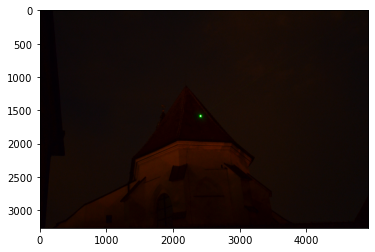

In [2]:
#img = cv2.imread("../dataset/honor/1.jpg")
img = cv2.imread("../dataset/images/DSC_2749.JPG")
img = cv2.imread("../dataset/images/DSC_2757.JPG")
# img = cv2.resize(img, [1600, 1060])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img.shape

(3264, 4928)

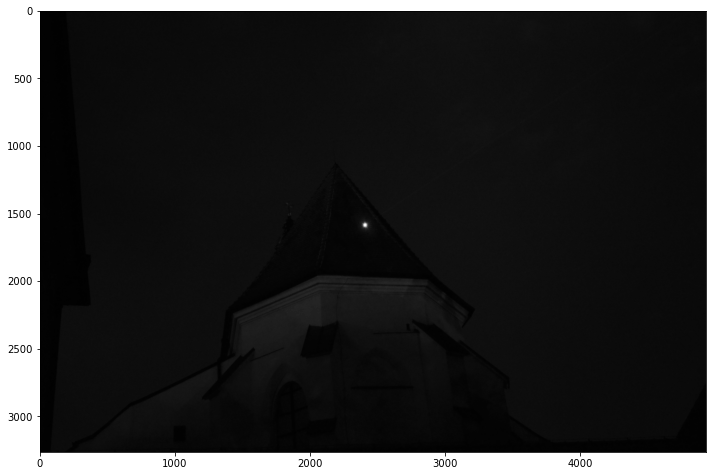

In [3]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(gray, cmap='gray')
fig.tight_layout()
fig.savefig("../files/honor/1_gray.png")
gray.shape

In [4]:
cols = np.sum(gray, axis=0)
cols.shape

(4928,)

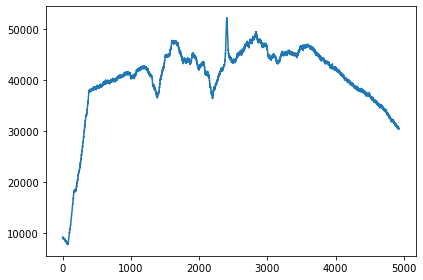

In [5]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(cols)
fig.tight_layout()
fig.savefig("../files/honor/1_gray_cols.png")

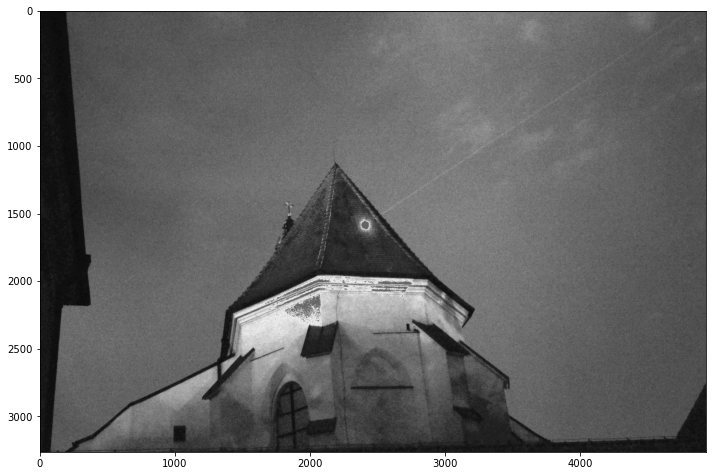

In [6]:
img_width = img.shape[1]
img_height = img.shape[0]

interval = 20
median = np.median(gray)
nobackgr = gray.copy()
nobackgr[nobackgr > median + interval] = median
nobackgr[nobackgr < median - interval] = median

fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(nobackgr, cmap='gray')
fig.tight_layout()
fig.savefig("../files/honor/1_removed_extremes.png")

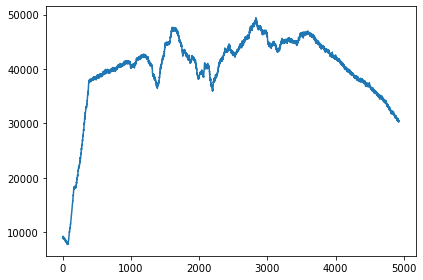

In [7]:
cols_nobackgr = np.sum(nobackgr, axis=0)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(cols_nobackgr)
fig.tight_layout()
fig.savefig("../files/honor/1_removed_extremes_cols.png")

## Removal of extreme intensitites using local information

In [8]:
# low_percentile = np.percentile(nobackgr, 10)
# high_percentile = np.percentile(nobackgr, 90)
#
#
# cleaned = nobackgr.copy()
# median_of_img = np.median(nobackgr)
# box_size = 100
# for x in range(0, img_width, box_size):
#     for y in range(0, img_height, box_size):
#         cell = nobackgr[y:y+box_size, x:x+box_size]
#         lp_cell = np.percentile(cell, 5)
#         hp_cell = np.percentile(cell, 95)
#         if lp_cell <= low_percentile and hp_cell >= high_percentile:
#             cleaned[y:y+box_size, x:x+box_size] = median_of_img
#
# fig, ax = plt.subplots(figsize=(10,8))
# ax.imshow(cleaned, cmap='gray')
# fig.tight_layout()

## Removing high intensity regions using blob extraction

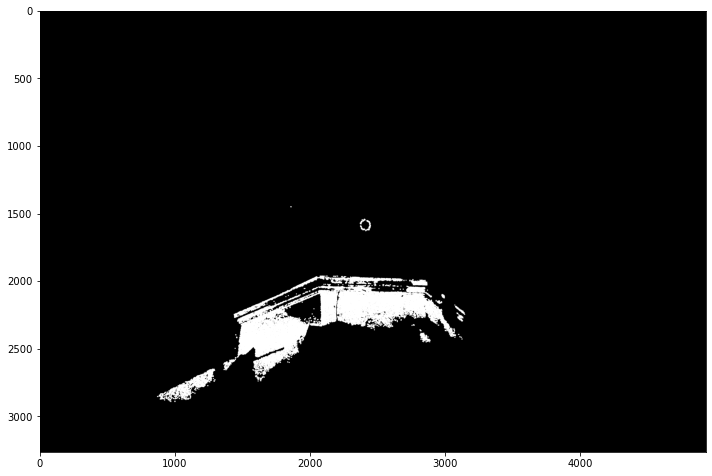

In [9]:
hp = np.percentile(nobackgr, 95)
ret, thres = cv2.threshold(nobackgr, thresh=hp, maxval=255, type=cv2.THRESH_BINARY)
binary = cv2.morphologyEx(thres, cv2.MORPH_OPEN, np.ones((7,7),np.uint8))
#binary = cv2.morphologyEx(binary, cv2.MORPH_DILATE, np.ones((7,7),np.uint8))

fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(binary, cmap='gray')
fig.tight_layout()

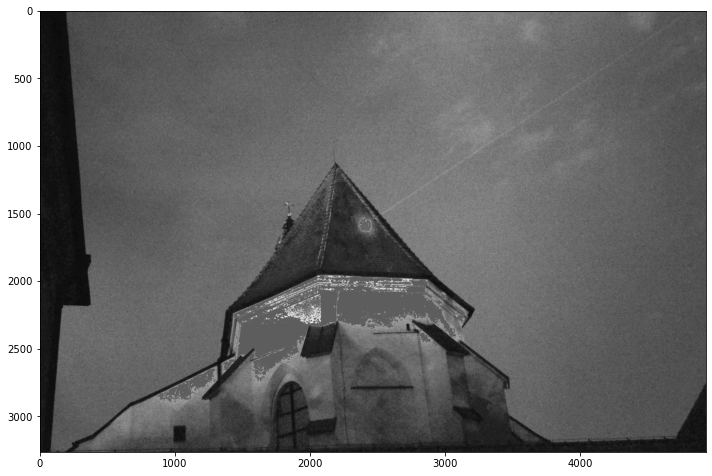

In [10]:
replacement_value = np.percentile(nobackgr, 40)
removed_blobs = nobackgr.copy()
removed_blobs[binary==255] = replacement_value

fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(removed_blobs, cmap='gray')
fig.tight_layout()

## Padding

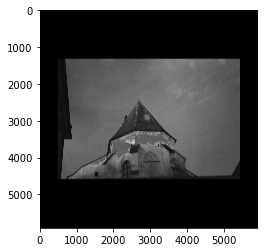

In [11]:
import math
# Pad the image before rotation, so that the whole image is visible
diagonal = math.ceil(math.sqrt(img_height ** 2 + img_width ** 2))
vertical_pad = diagonal - img_height
vertical_pad_half = vertical_pad // 2
horizontal_pad = diagonal - img_width
horizontal_pad_half = horizontal_pad // 2

padded = np.pad(removed_blobs, [[vertical_pad_half, vertical_pad_half],
                           [horizontal_pad_half, horizontal_pad_half]],
                'constant', constant_values=0)
plt.imshow(padded, cmap='gray')

## Rotation

Time it took to rotate [ms]:  277.8184413909912


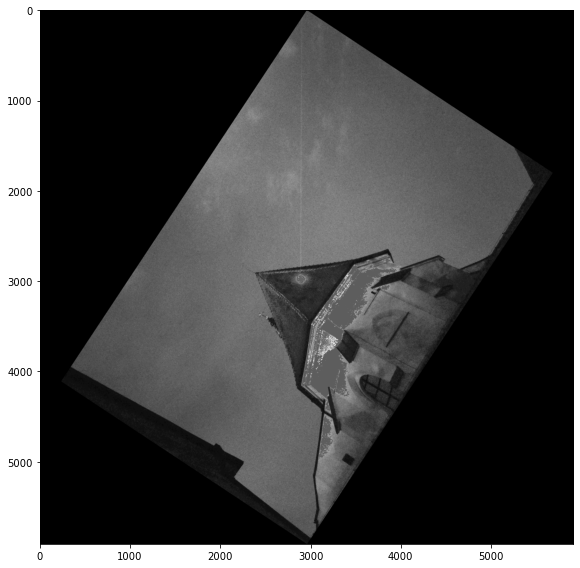

In [12]:
(h, w) = padded.shape[:2]
(cX, cY) = (w // 2, h // 2)
# 39.5
# DSC -78
rot_degrees = 56.5
M = cv2.getRotationMatrix2D((cX, cY), rot_degrees, 1.0)
start = time.time()
rotated = cv2.warpAffine(padded, M, (w, h))
print("Time it took to rotate [ms]: ", (time.time() - start) * 1000)
fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(rotated, cmap='gray')
fig.tight_layout()
# fig.savefig("../files/honor/1_rotated.png")

/tmp/ipykernel_18666/4066271451.py:7: RuntimeWarning: invalid value encountered in true_divide
  cols_nobackgr /= nonzero_counts


array([0., 0., 0., ..., 0., 0., 0.])

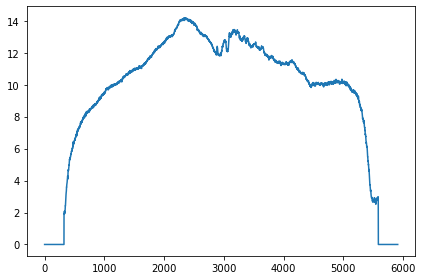

In [13]:
rotated_copy = rotated.copy()
rotated_copy = rotated_copy[:,:]
img_height = rotated_copy.shape[0]
cols_nobackgr = np.sum(rotated_copy, axis=0).astype(float)

nonzero_counts = np.count_nonzero(rotated_copy, axis=0)
cols_nobackgr /= nonzero_counts
cols_nobackgr[np.isnan(cols_nobackgr)] = 0

min_nonzero_counts = 200 # statistically significant
cols_nobackgr[nonzero_counts < min_nonzero_counts] = 0

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(cols_nobackgr)
fig.tight_layout()
fig.savefig("../files/honor/1_rotated_cols.png")
cols_nobackgr

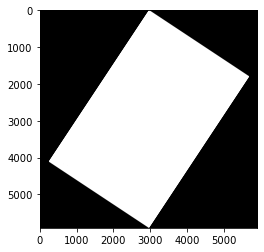

In [14]:
rotated_copy = rotated.copy()
rotated_copy[rotated_copy > 0] = 1
plt.imshow(rotated_copy, cmap='gray')

In [15]:
def convolve(img, filter):
    #deriv_filter = np.array([1, 1, 1, -1, -1, -1])
    convolved = np.convolve(img, filter, mode='same')
    #clear = 200
    #convolved[:clear] = convolved[clear]
    #convolved[-clear:] = convolved[-clear]
    # convolved_abs = np.abs(convolved)
    convolved[convolved < 0] = 0
    return convolved



5581


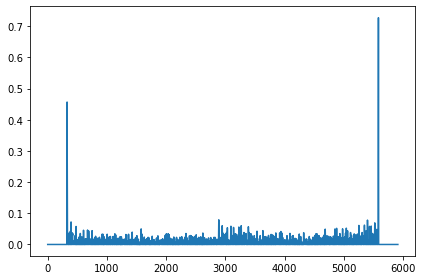

In [16]:
# deriv_filter = np.array([-1, -1, -1,-1,-1, 0, 0, 0, 1, 1, 1, 1, 1])
#deriv_filter = np.array([1, 1, 1, 1, 1, -2, -2, -2, 1, 1, 1, 1, 1], dtype=float)
deriv_filter = np.array([-1, -1, -1, -1, -1, 2, 2, 2,2,2, -1, -1, -1, -1, -1], dtype=float)
deriv_filter /= np.sum(np.abs(deriv_filter))

convolved = convolve(cols_nobackgr, deriv_filter)

col_index = np.argmax(convolved)
print(col_index)
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(convolved)
fig.tight_layout()
fig.savefig("../files/honor/1_convolution_of_cols.png")

array([0., 0., 0., ..., 0., 0., 0.])

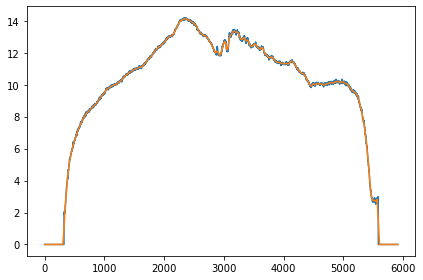

In [17]:
filter = np.ones([40], dtype=float)
filter /= np.sum(np.abs(filter))

convolved_average = convolve(cols_nobackgr, filter)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(cols_nobackgr[:])
ax.plot(convolved_average)
fig.tight_layout()
convolved_average

5583

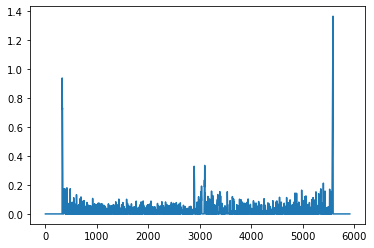

In [18]:
d = (cols_nobackgr - convolved_average)
d[d < 0] = 0
d[d == np.nan] = 0
d[np.isnan(d)] = 0
plt.plot(d)
np.argmax(d)

Remove values created by convolution of zeros.
Sequentilly, this would be rewriting values in a distance from zeros
reachable by the filter used previously for convolution.

2887

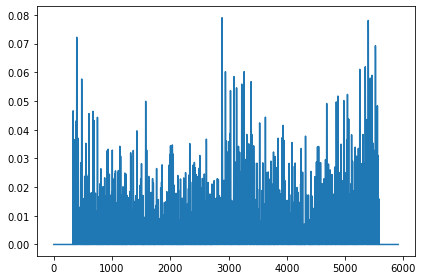

In [19]:
# First two lines are parametrizable.
filter_of_previous_length = np.ones([deriv_filter.shape[0]])
cols_copy = convolved.copy()
mask_where_zeros = (cols_nobackgr == 0).astype(int)
convolved_mask = convolve(mask_where_zeros, filter_of_previous_length)
cols_copy[convolved_mask > 0] = 0

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(cols_copy)
fig.tight_layout()
np.argmax(cols_copy)

(array([232., 223., 207., 159., 164., 171., 160., 151., 153., 131., 127.,
         88.,  87.,  74.,  73.,  59.,  47.,  51.,  38.,  35.,  37.,  25.,
         20.,  18.,  15.,   7.,   9.,  14.,   9.,   6.,   6.,   9.,   9.,
          3.,   6.,   3.,   3.,   4.,   3.,   3.,   1.,   1.,   0.,   3.,
          1.,   1.,   1.,   0.,   0.,   3.]),
 array([3.77471756e-06, 1.58426680e-03, 3.16475889e-03, 4.74525098e-03,
        6.32574306e-03, 7.90623515e-03, 9.48672724e-03, 1.10672193e-02,
        1.26477114e-02, 1.42282035e-02, 1.58086956e-02, 1.73891877e-02,
        1.89696798e-02, 2.05501718e-02, 2.21306639e-02, 2.37111560e-02,
        2.52916481e-02, 2.68721402e-02, 2.84526323e-02, 3.00331244e-02,
        3.16136164e-02, 3.31941085e-02, 3.47746006e-02, 3.63550927e-02,
        3.79355848e-02, 3.95160769e-02, 4.10965690e-02, 4.26770611e-02,
        4.42575531e-02, 4.58380452e-02, 4.74185373e-02, 4.89990294e-02,
        5.05795215e-02, 5.21600136e-02, 5.37405057e-02, 5.53209977e-02,
        5.

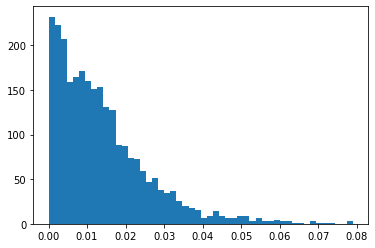

In [20]:
plt.hist(cols_copy[cols_copy > 0],bins=50)

In [21]:
# Values that are significantly distant from others
# 10 % distance from max value, if contains max K values
vals = cols_copy[cols_copy > 0]
min = np.min(vals)
max = np.max(vals)
interval = max - min
candidates = vals[vals > 0.85 * interval]
candidates

array([0.07221228, 0.06844003, 0.07888316, 0.07902838, 0.06847772,
       0.07003971, 0.07808966, 0.07407167, 0.06924184])

In [22]:
mean = np.mean(vals)
max / mean

5.687686295000805

In [23]:
med = np.median(vals)
max / med

7.071593873300836

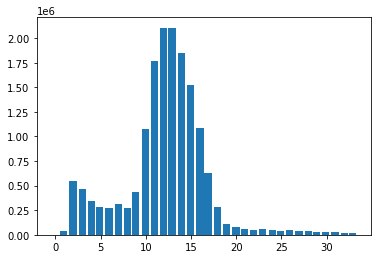

In [24]:
histogram, bin_edges = np.histogram(nobackgr, bins=256)

plt.bar(bin_edges[0:-1], histogram)  # <- or here
plt.show()

In [25]:
nobackgr.shape



(3264, 4928)